In [128]:
from datetime import datetime, timedelta
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [129]:
# Function to parse job time string to timedelta
def parse_job_time(job_time_str):
    hours, minutes, seconds = map(int, job_time_str.split(':'))
    return timedelta(hours=hours, minutes=minutes, seconds=seconds)


# Function to parse the start time string to datetime
def parse_start_time(job_time_str):
    return datetime.strptime(job_time_str, '%Y-%m-%d %H:%M:%S')


# Function to get the job times for each benchmark (in seconds), for all runs (files)
def get_batch_times(files):
    # Create a dictionary with all the key-values : job_name --> [t1, t2, t3]
    batch_execution_times = {}
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Job:'):
                    batch_name = line.split(': ')[1].strip()
                elif line.startswith('Job time:'):
                    job_time_str = line.split(': ')[1].strip()
                    job_time = parse_job_time(job_time_str)
                    if batch_name in batch_execution_times:
                        batch_execution_times[batch_name].append(job_time.total_seconds())
                    else:
                        batch_execution_times[batch_name] = [job_time.total_seconds()]
    return batch_execution_times


# Function to calculate mean and standard deviation of job time for each batch application
def calculate_batch_means_and_stds(files):
    batch_execution_times = get_batch_times(files)
    # Create mean and std dictionaries with all key-values: job_name --> mean and job_name --> std
    batch_means = {}
    batch_stds = {}
    for batch_name, execution_times in batch_execution_times.items():
        batch_means[batch_name] = statistics.mean(execution_times)
        batch_stds[batch_name] = statistics.stdev(execution_times)

    return batch_means, batch_stds


# Function to get the total job time (in seconds) for each file
def get_total_job_times(files):
    job_times = list()
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Total time:'):
                    job_time = parse_job_time(line.split(': ')[1].strip())
                    job_times.append(job_time.total_seconds())
    return job_times


# Function to calculate relative starting times in seconds for each job
def calculate_relative_start_times(files):
    relative_start_times = list()
    for file in files:
        start_times = list()
        with open(file, 'r') as f:
            for line in f:
                if line.startswith('Start time:'):
                    start_time = parse_start_time(line.split(': ')[1].strip())
                    start_times.append(start_time)
        min_start_time = min(start_times)
        relative_start_times.append([(start_time - min_start_time).total_seconds() for start_time in start_times])
    
    return relative_start_times


# Function to parse ts_start and ts_end to datetime objects
def parse_timestamp(timestamp_str):
    return datetime.fromtimestamp(int(timestamp_str) / 1000)


# Function to parse the mcperf file
def parse_mcperf_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    
    header = lines[0].split()
    column_indices = {header[i]: i for i in range(len(header))} # To get automatically the correct columns instead of hardcoding indeces
    data = {'p95': [], 'QPS':[], 'target':[], 'ts_start': [], 'ts_end': []}
    for line in lines[1:]:  # To skip the header line
        parts = line.split()
        data['p95'].append(float(parts[column_indices['p95']]))
        data['QPS'].append(float(parts[column_indices['QPS']]))
        data['target'].append(float(parts[column_indices['target']]))
        data['ts_start'].append(parse_timestamp(parts[column_indices['ts_start']]))
        data['ts_end'].append(parse_timestamp(parts[column_indices['ts_end']]))

    df = pd.DataFrame(data)
    return df


# Function to arrange times in a format convenient for plotting
def arrange_times(batch_times, total_times, n_runs):
    arranged_times = list()
    for i in range(n_runs):
        tmp = list()
        for value in batch_times.values():
            tmp.append(value[i])
        tmp.append(total_times[i])
        arranged_times.append(tmp)
    return arranged_times

In [130]:
files = ["measurements/tmp_3/pods_0.txt", "measurements/tmp_3/pods_1.txt", "measurements/tmp_3/pods_2.txt"]
mcperf_files = ["measurements/tmp_2/mcperf_0.txt", "measurements/tmp_2/mcperf_1.txt", "measurements/tmp_2/mcperf_2.txt"]
n_runs = 3

In [131]:
# Calculate batch means and standard deviations
batch_means, batch_stds = calculate_batch_means_and_stds(files)

print('Batch Application Means:')
for batch_name, mean in batch_means.items():
    print(f'{batch_name}: {mean:.2f} seconds')

print('\nBatch Application Standard Deviations:')
for batch_name, std in batch_stds.items():
    print(f'{batch_name}: {std:.2f} seconds')

# Get total job times (in seconds) for each file and convert them to seconds
total_job_times = get_total_job_times(files)
print('\nTotal Job Time Across All Files:', total_job_times)

# Calculate mean and standard deviation of the total time to complete all jobs (makespan)
makespan_mean = statistics.mean(total_job_times)
makespan_stdev = statistics.stdev(total_job_times)
print('\nMakespan Mean:', makespan_mean, 'seconds')
print('Makespan Standard Deviation:', makespan_stdev, 'seconds')


Batch Application Means:
parsec-blackscholes: 51.67 seconds
parsec-canneal: 130.00 seconds
parsec-dedup: 20.00 seconds
parsec-ferret: 140.33 seconds
parsec-freqmine: 169.67 seconds
parsec-radix: 18.67 seconds
parsec-vips: 109.33 seconds

Batch Application Standard Deviations:
parsec-blackscholes: 2.89 seconds
parsec-canneal: 2.65 seconds
parsec-dedup: 6.08 seconds
parsec-ferret: 9.81 seconds
parsec-freqmine: 15.18 seconds
parsec-radix: 0.58 seconds
parsec-vips: 30.44 seconds

Total Job Time Across All Files: [187.0, 196.0, 184.0]

Makespan Mean: 189.0 seconds
Makespan Standard Deviation: 6.244997998398398 seconds


In [132]:
# Get the batch times and the total times across all runs
batch_times = get_batch_times(files)
total_times = get_total_job_times(files)

# Arrange times for convenient plotting
arranged_times = arrange_times(batch_times, total_times, n_runs)

# Get the relative job time spans wrt the first run job(s)
relative_start_times = calculate_relative_start_times(files)

# Get dataframes of interest from mcperf files and compute memcached timespan
mcperf_dfs = list()
memcached_spans = list()
for file in mcperf_files:
    df = parse_mcperf_file(file)
    memcached_span = (df['ts_end'].iloc[-1] - df['ts_start'].iloc[0]).total_seconds()
    memcached_spans.append(memcached_span)
    df['ts_span'] = (df['ts_end'] - df['ts_start']).dt.total_seconds()
    delay = df['ts_start'] - df['ts_end'].shift(1)
    delay[0] = pd.Timedelta(seconds=0)
    df['cum_ts_span'] = df['ts_span'] + delay.dt.total_seconds()
    df['cum_ts_span'] = df['cum_ts_span'].cumsum()
    df = df[['p95', 'QPS', 'target', 'ts_span', 'cum_ts_span']]
    mcperf_dfs.append(df)

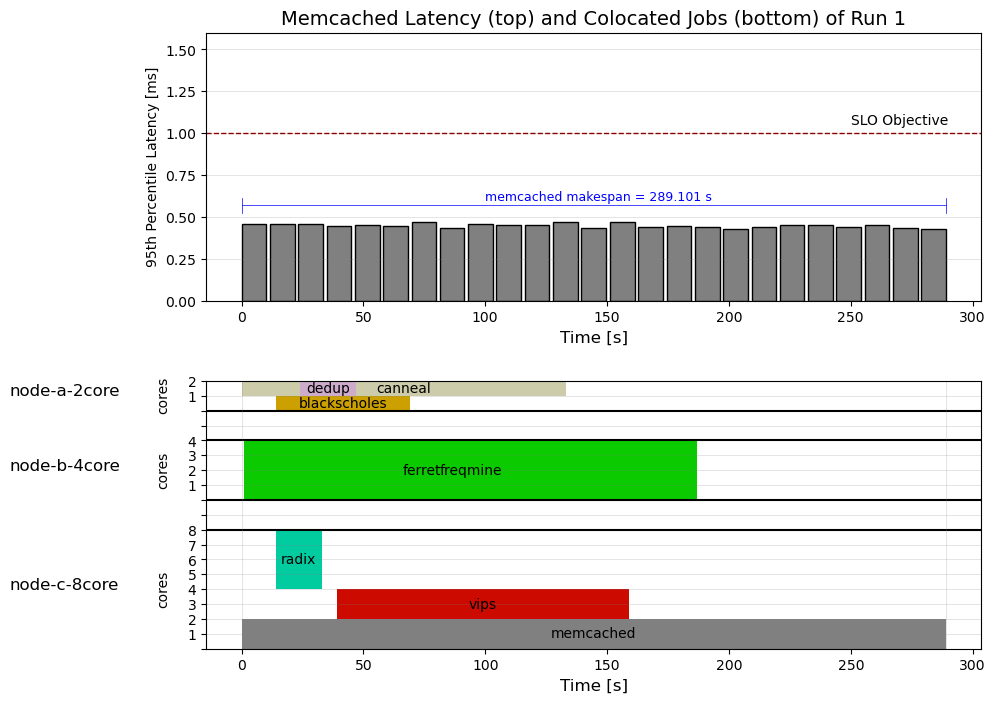

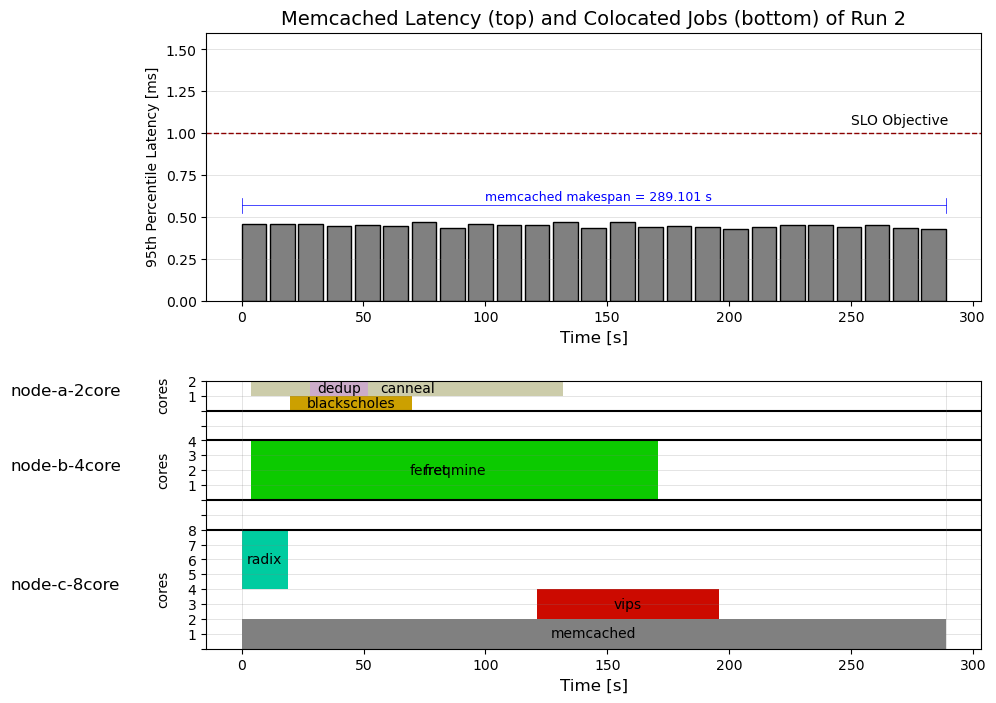

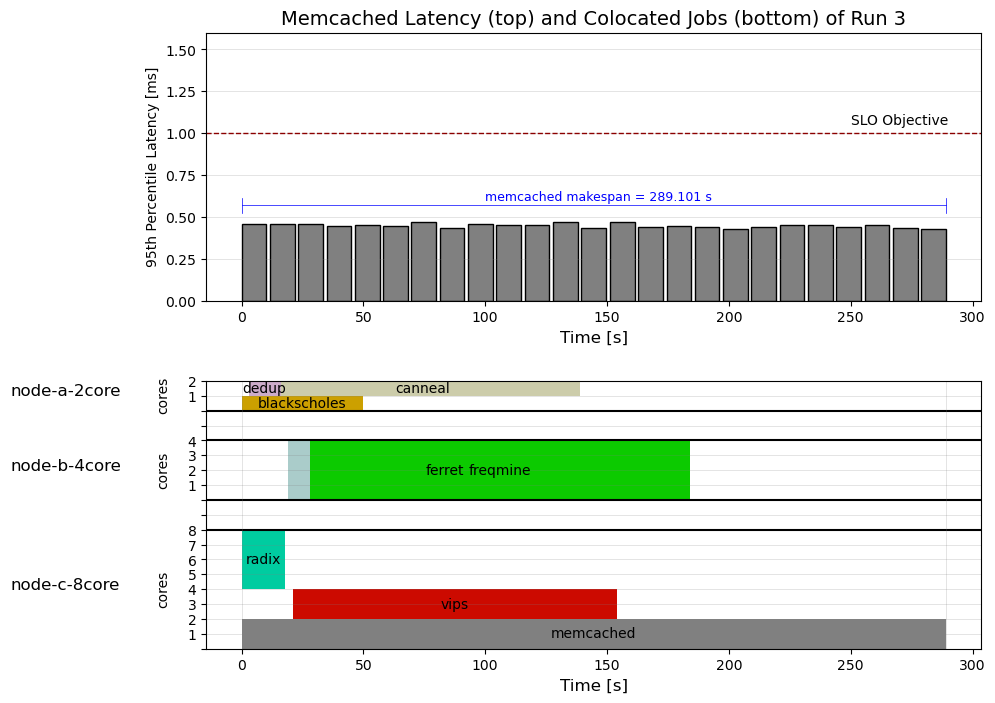

In [133]:
# Create plot 3a
colors = {'canneal': '#CCCCAA', 'dedup': '#CCACCA', 'blackscholes': '#CCA000',
          'ferret': '#AACCCA', 'freqmine': '#0CCA00',
          'memcached': 'grey', 'radix': '#00CCA0', 'vips': '#CC0A00'}

for i in range(n_runs):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8), dpi=100)
    fig.subplots_adjust(hspace=0.3)
    
    ## ------ First Subplot ------ ##
    x = df['cum_ts_span'] - df['cum_ts_span'][0]/2    #offset to align the starting time of the forst copntainer to x=0
    y = df['p95']/1000
    ax1.bar(x, y, width=df['ts_span'], color='grey', edgecolor='black', linewidth=1)
    slo_objective = ax1.axhline(y=1, color='darkred', linestyle='--', linewidth=1)
    ax1.annotate('SLO Objective', xy=(250, 1.05), color='black')
    ax1.plot([0, df['cum_ts_span'].iloc[-1]], [y.max() + 0.1, y.max() + 0.1], color='blue', linestyle='-', linewidth=0.5)
    ax1.plot([0, 0], [y.max() + 0.05, y.max() + 0.14], color='blue', linestyle='-', linewidth=0.5)
    ax1.plot([df['cum_ts_span'].iloc[-1], df['cum_ts_span'].iloc[-1]], [y.max() + 0.05, y.max() + 0.14], color='blue', linestyle='-', linewidth=0.5)
    ax1.annotate(f'memcached makespan = {df['cum_ts_span'].iloc[-1]} s', xy=(100, y.max() + 0.125), color='blue', fontsize=9)
    
    # Style
    ax1.set_xticks([0, 50, 100, 150, 200, 250, 300])
    ax1.set_xlabel("Time [s]", fontsize = 12)
    
    ax1.set_ylim((0, 1.6))
    ax1.set_yticks(np.arange(0, 1.75, 0.25).tolist())
    ax1.set_ylabel('95th Percentile Latency [ms]')
    
    ax1.set_title('Memcached Latency (top) and Colocated Jobs (bottom) of Run ' + str(i+1), fontsize = 14)
    ax1.grid(axis='y', color='grey', linewidth=0.5, alpha=0.3)
    
    ## ------ Second Subplot ------ ##
    # In order of appearance in pods_{i}.txt (as in arranged_times and relative_start_times):
    # Blackscholes
    ax2.broken_barh([(relative_start_times[i][0], arranged_times[i][0])], (16, 1), facecolors = colors['blackscholes'])
    ax2.annotate('blackscholes', ((relative_start_times[i][0]*2 + arranged_times[i][0])/2, 16.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Canneal
    ax2.broken_barh([(relative_start_times[i][1], arranged_times[i][1])], (17, 1), facecolors = colors['canneal'])
    ax2.annotate('canneal', ((relative_start_times[i][1]*2 + arranged_times[i][1])/2, 17.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')

    # Dedup
    ax2.broken_barh([(relative_start_times[i][2], arranged_times[i][2])], (17, 1), facecolors = colors['dedup'])
    ax2.annotate('dedup', ((relative_start_times[i][2]*2 + arranged_times[i][2])/2, 17.5), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Ferret
    ax2.broken_barh([(relative_start_times[i][3], arranged_times[i][3])], (10, 4), facecolors = colors['ferret'])
    ax2.annotate('ferret', ((relative_start_times[i][3]*2 + arranged_times[i][3])/2, 12), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Freqmine
    ax2.broken_barh([(relative_start_times[i][4], arranged_times[i][4])], (10, 4), facecolors = colors['freqmine'])
    ax2.annotate('freqmine', ((relative_start_times[i][4]*2 + arranged_times[i][4])/2, 12), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Radix
    ax2.broken_barh([(relative_start_times[i][5], arranged_times[i][5])], (4, 4), facecolors = colors['radix'])
    ax2.annotate('radix', ((relative_start_times[i][5]*2 + arranged_times[i][5])/2, 6), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Vips
    ax2.broken_barh([(relative_start_times[i][6], arranged_times[i][6])], (2, 2), facecolors = colors['vips'])
    ax2.annotate('vips', ((relative_start_times[i][6]*2 + arranged_times[i][6])/2, 3), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Memcached
    ax2.broken_barh([(0, memcached_spans[i])], (0, 2), facecolors = colors['memcached'])
    ax2.annotate('memcached', (memcached_spans[i]/2, 1), color = 'black', 
                 horizontalalignment='center', verticalalignment='center')
    
    # Style
    ax2.set_xticks([0, 50, 100, 150, 200, 250, 300])
    ax2.set_xlabel("Time [s]", fontsize = 12)
    
    ax2.set_ylim(0, 18)
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    ax2.set_yticklabels(['', '1', '2', '3', '4', '5', '6', '7', '8', '', '', '1', '2', '3', '4', '', '', '1', '2'])
    
    ax2.grid(axis='y', color='grey', linewidth=0.5, alpha=0.3)
    ax2.axhline(y=8, color='black', linestyle='-')
    ax2.axhline(y=10, color='black', linestyle='-')
    ax2.axhline(y=14, color='black', linestyle='-')
    ax2.axhline(y=16, color='black', linestyle='-')
    ax2.axvline(x=0, color='grey', linewidth=0.5, alpha=0.3)
    ax2.axvline(x=memcached_spans[i], color='grey', linewidth=0.5, alpha=0.3)
    
    ax2.text(-95, 4, 'node-c-8core', rotation=0, fontsize=12)
    ax2.text(-35, 3, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-95, 12, 'node-b-4core', rotation=0, fontsize=12)
    ax2.text(-35, 11, 'cores', rotation=90, fontsize=10)
    
    ax2.text(-95, 17, 'node-a-2core', rotation=0, fontsize=12)
    ax2.text(-35, 16, 'cores', rotation=90, fontsize=10)
    
    plt.show()
    #plt.savefig("plot_" + str(i) + ".pdf", bbox_inches = "tight")